In [1]:
import yaml


import torch
import torch.utils.data as data
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from pprint import pprint

from csfnst.utils import LRFinder, load_image, rename_network_layers, replace_network_layers
from csfnst.fastneuralstyle.networks import StylizedNet, BottleneckType, NetworkArchitecture
from csfnst.losses import PerceptualLoss

/home/s0555912/venv/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def get_runs(config_file):
    config = yaml.load(open(config_file, 'r'), Loader=yaml.Loader)

    runs = [
        {
            'name': list(run.keys())[0],
            **config['defaults'],
            **run[list(run.keys())[0]],
            'network': NetworkArchitecture[
                run[list(run.keys())[0]]['network']
                if 'network' in run[list(run.keys())[0]].keys()
                else config['defaults']['network']
            ],
            'bottleneck_type': BottleneckType[
                run[list(run.keys())[0]]['bottleneck_type']
                if 'bottleneck_type' in run[list(run.keys())[0]].keys()
                else config['defaults']['bottleneck_type']
            ]
        }
        for run in config['runs']
    ]

    return runs

In [3]:
device_type = 'cuda'
run_name = 'candy'
config_file = '../config/production.yml'
configs = get_runs(config_file)
config = [config for config in configs if config['name'] == run_name][0]
device = torch.device('cuda' if torch.cuda.is_available() and device_type == 'cuda' else 'cpu')

# pprint(config)

In [4]:
model = StylizedNet(
    channel_multiplier=config['channel_multiplier'],
    expansion_factor=config['expansion_factor'],
    bottleneck_type=config['bottleneck_type'],
    bottleneck_size=config['bottleneck_size'],
    intermediate_activation_fn=config['intermediate_activation_fn'],
    final_activation_fn=config['final_activation_fn']
)

In [5]:
dataset = datasets.ImageFolder(
    config['dataset_path'],
    transform=transforms.Compose([
        transforms.RandomResizedCrop(config['content_image_size'])
        if config['augmentation'] else
        transforms.Compose([
            transforms.Resize(int(config['content_image_size'])),
            transforms.CenterCrop(int(config['content_image_size']))
        ]),
        transforms.ToTensor()
    ])
)



dataloader = (
    (images, images) 
    for images, _
    in data.DataLoader(
        dataset,
        batch_size=int(config['batch_size']),
        shuffle=True,
        num_workers=8
    )
)

In [6]:
style_image_file = f'../images/style/{config["style_image"]}'
style_image = load_image(style_image_file, size=config['style_image_size']).to(device)

loss_network = rename_network_layers(
    replace_network_layers(
        models.vgg16(pretrained=True).features[:23],
        'MaxPool2d',
        'AvgPool2d'
    )
).to(device).eval()

criterion = PerceptualLoss(
    model=loss_network,
    content_layers=['relu3_3'],
    style_layers=['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'],
    style_image=style_image,
    content_weight=float(config['content_weight']),
    style_weight=float(config['style_weight']),
    total_variation_weight=float(config['total_variation_weight'])
)


Learning rate search finished. See the graph with {finder_name}.plot()


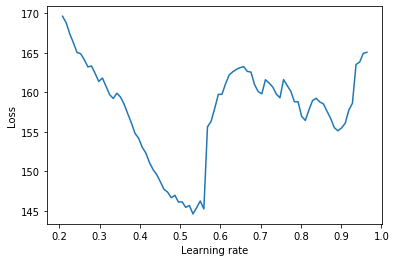

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device_type)
lr_finder.reset()
lr_finder.range_test(dataloader, end_lr=1, num_iter=100, step_mode='linear')
lr_finder.plot(log_lr=False)